In [1]:
%env PATH=/usr/local/cuda-11.5/bin:$PATH

env: PATH=/usr/local/cuda-11.5/bin:$PATH


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
from pinns.prelude import *
from pinns.domain import Sphere
from pinns.calc import divergence
from pinns.krr import krr, rbf
from pinns.elm import elm
from pinns.pde import poisson_dirichlet_qp_mc, poisson_dirichlet_ecqp_mc
from scipy.stats.qmc import Sobol

import itertools
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)

In [4]:
domain = Sphere(1., (0., 0., 0.))
x_dom = array(Sobol(3, seed=0).random_base2(12))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(9))
x_bnd = domain.transform_bnd(x_bnd)

x_support_dom = x_dom[:2**8]
x_support_bnd = x_bnd[:2**6]


In [20]:
def plot_result(sol, ax):
    plt.sca(ax)
    N = 200
    x = np.linspace(-1, 1, N)
    z = np.linspace(-1, 1, N)
    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))
    phi[np.linalg.norm(X, axis=-1) > 1.] = np.nan

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    plt.colorbar(p)


def plot_model(model):
    fig = plt.figure(figsize=(8, 3))
    ax1, ax2 = fig.subplots(1, 2)
    fig.subplots_adjust(wspace=0.4)
    plot_result(model, ax1)
    ax1.set_title("Model")    
    plot_result(lambda x: abs(model(x) - norm(x, axis=-1) + 1), ax2)
    ax2.set_title("Absolute error")


from jaxopt import EqualityConstrainedQP


def compute_l(h, x_dom, x_bnd):
    Ld = vmap(h)(x_dom)
    Lb = vmap(h)(x_bnd)
    L = concatenate([Lb, Ld])
    Q = L.T @ L
    k = - 2 * jnp.sum(L, axis=0)
    
    eq = EqualityConstrainedQP(
        #refine_regularization=1, refine_maxiter=30, 
        tol=1e-8, maxiter=3000
    )
    p = eq.run(
        params_obj=(Q, k),
        params_eq=(Lb, zeros(len(x_bnd)))
    ).params.primal
    return lambda x: h(x) @ p

weights = array(Sobol(4, seed=12345).random_base2(5))
Wl = (weights[:, :3] * 2 - 1)
bl = (weights[:, 3] * 2 - 1)
hl = lambda x: sin(Wl @ x + bl)
l = compute_l(hl, x_dom, x_bnd)

In [22]:
weights = array(Sobol(4, seed=12345).random_base2(8))
W = (weights[:, :3] * 2 - 1)
b = (weights[:, 3] * 2 - 1)


m = lambda x: x / norm(x)
f = lambda x: -divergence(m)(x)
l = lambda x: (1 - norm(x) ** 2)
n = lambda x: jax.nn.normalize(-grad(l)(x))
h = lambda x: tanh(W @ x + b)
#h = lambda x: exp(- 40 * (W @ x + b)**2)
u = lambda x: l(x) * h(x)
#u = lambda x: l(x) * exp(-1 * (W @ x + b)**2)
g1 = lambda x: 0.

phi1 = poisson_dirichlet_qp_mc(u, g1, x_dom, f, tol=1e-9, maxiter=4000)


In [23]:
def phi2_solution(x, x_bnd):
    eps = 1e-7
    def g(y):
        return dot(m(y), n(y)) - dot(grad(phi1)(y), n(y))
    
    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)
    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return (4 * pi * 1. ** 2) / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)

In [24]:
_x_bnd = array(Sobol(2, seed=123).random_base2(14))
_x_bnd = domain.transform_bnd(_x_bnd)
phi_bnd = phi2_solution(x_bnd, _x_bnd)

In [25]:
X = concatenate([x_bnd, x_dom])
g2 = elm(x_bnd, phi_bnd, W, b, ridge=0.001)
phi2 = poisson_dirichlet_qp_mc(u, g2, x_dom)

phi_nn = vmap(lambda x: phi1(x) + phi2(x))

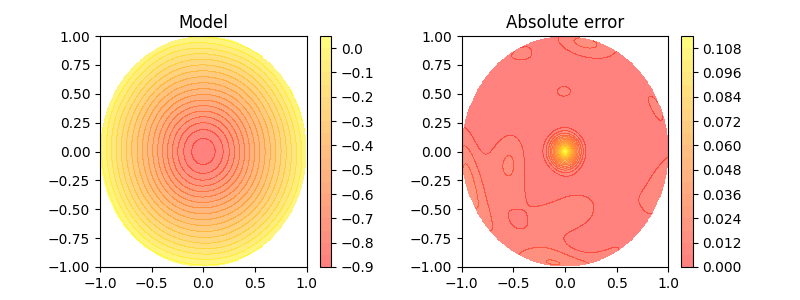

In [26]:
plot_model(phi_nn)

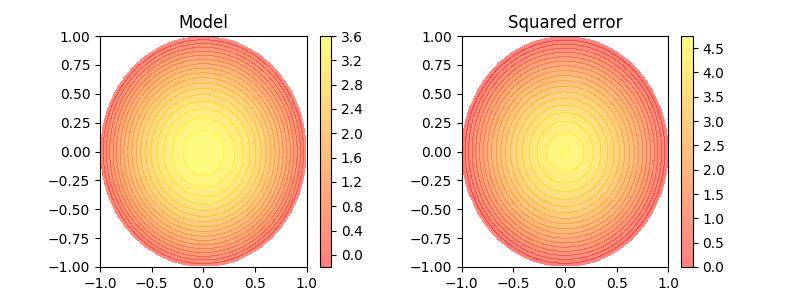

In [14]:
plot_model(vmap(l))

In [15]:
sol = lambda x: norm(x, axis=-1) - 1
sqrt(mean((phi_nn(x_dom) - sol(x_dom))**2))

DeviceArray(0.00895886, dtype=float64)

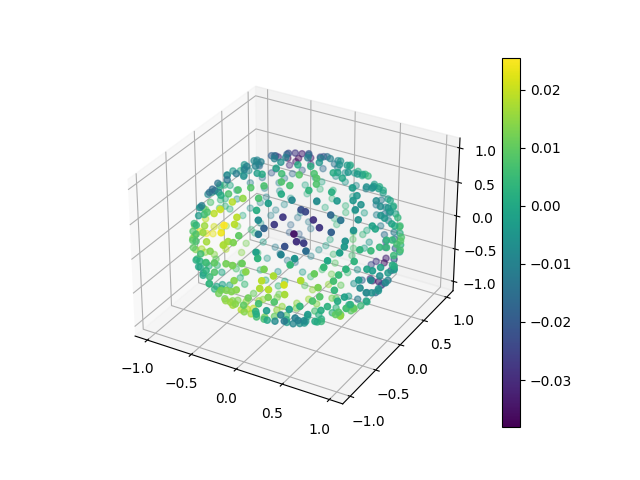

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(x_bnd[:, 0], x_bnd[:, 1], x_bnd[:, 2], c=phi_nn(x_bnd))
plt.colorbar(p)

In [17]:
net = lambda p, x: h(x) @ p['params']['p']
key = random.PRNGKey(42)
key, subkey = random.split(key, 2)
p0 = random.uniform(key, (2**6,))

tx = optax.adam(0.001)
init_state = TrainState.create(
    apply_fn=net, 
    params=freeze({"p": p0}),
    tx=tx
)

def loss(params, x_dom, x_bnd):
    _dom_loss = lambda x, _, p: (net(p, x) - 1) ** 2
    _bnd_loss = lambda _, x, p: net(p, x) ** 2

    dom_loss = mean(vmap(_dom_loss, (0, None, None))(x_dom, x_bnd, params))
    bnd_loss = mean(vmap(_bnd_loss, (None, 0, None))(x_dom, x_bnd, params))
    _loss = dom_loss + 10000 * bnd_loss
    return _loss, {'dom_loss': dom_loss, 'bnd_loss': bnd_loss}

In [15]:
@jit
def make_batches(rng):
    batches = 24
    k1, k2 = random.split(rng)
    batch_size_dom = x_dom.shape[0] // batches
    batch_size_bnd = x_bnd.shape[0] // batches

    perms_dom = jax.random.permutation(k1, x_dom.shape[0])
    perms_dom = perms_dom[:batches * batch_size_dom]  # skip incomplete batch
    perms_dom = perms_dom.reshape((batches, batch_size_dom))

    perms_bnd = jax.random.permutation(k2, x_bnd.shape[0])
    perms_bnd = perms_bnd[:batches * batch_size_bnd]  # skip incomplete batch
    perms_bnd = perms_bnd.reshape((batches, batch_size_bnd))

    return x_dom[perms_dom, :], x_bnd[perms_bnd, :]

In [16]:
from pinns.opt import run_epoch

#state = init_state
for epoch in range(0, 2000):
    key, subkey = random.split(key)
    data = make_batches(subkey)
    state, epoch_metrics = run_epoch(state, loss, data)
    if epoch % 100 == 0:
        epoch_metrics = tree_map(mean, epoch_metrics)
        print(f"train epoch: {epoch}, dom_loss: {epoch_metrics['dom_loss']:.4e}, bnd_loss: {epoch_metrics['bnd_loss']:.4e}")

#params1 = {'params': state.params}

NameError: name 'state' is not defined